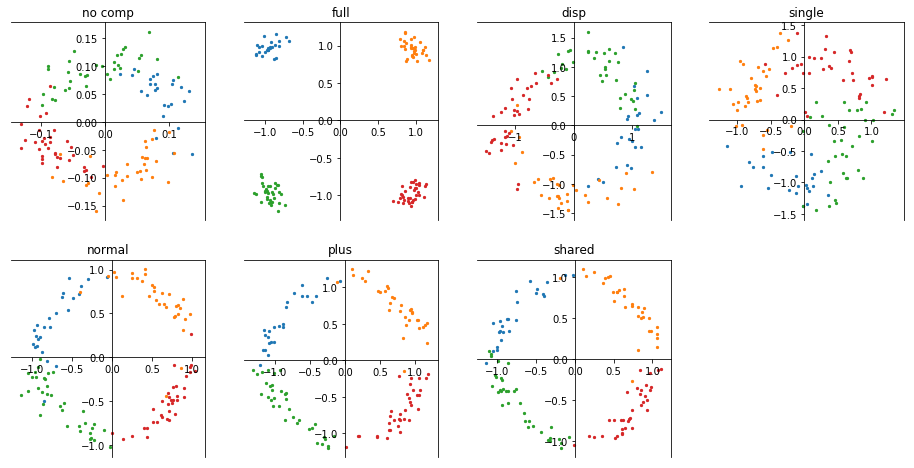

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import config
from Transmitter import Tx
from Receiver import  Rx
from Fiber import Fiber
from train_model import test_model

# Initializing the system
k = 1
tx = Tx()
rx = Rx()
tx.set_power([55,55,55])
rx.set_power([55,55,55])
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch,generate_noise=True)

# load model
show_path = 'ckpt-set/ckpt-W120-D3/'   
fig_path =  '/Users/xinyu/Desktop/WDM_Code/report/img/expriment/'
comp = {}
# 现在一共有三个模型
train_model_names = ['normal', 'plus','shared']   # 4 models
model_names = ['disp', 'single'] + train_model_names            # 6 models
all_names = ['no comp','full'] + model_names                    # 8 models
comp['disp'] = Fiber(tx.lam_set[k:k+1], length=1e5, alphaB=-0.2, n2=0, disp=-17, dz=5e3, Nch=1)
comp['single'] = Fiber(tx.lam_set[k:k+1], length=1e5, alphaB=-0.2, n2=-2.7e-20, disp=-17, dz=1e3, Nch=1)
comp['full'] = Fiber(tx.lam_set, length=1e5, alphaB=-0.2, n2=-2.7e-20, disp=-17, dz=1e3, Nch=config.Nch)
for name in train_model_names:
    comp[name] = torch.load(show_path + name + '_best.pt',map_location=torch.device('cpu'))['model']

########################### Fiber #############################
# fiber channel
x, symbol_stream, bit_stream = tx.wdm_signal_sample()
y = fiber(x)
z = {}

# compensation
z['full'] = comp['full'](y)
for name in model_names:
    z[name] = comp[name](y[k:k+1])

# receiver side
I = {}
I['no comp'] = rx.filter(y[k], Nch=k)
I['full'] = rx.filter(z['full'][k],Nch=k)
for name in model_names:
    I[name] = rx.filter(z[name][0], Nch=k)

# show constellation

plt.figure(figsize=(16,8))

for i,name in enumerate(all_names):
    plt.subplot(241+i)
    rx.show_symbol(I[name], symbol_stream[k])
    plt.title(name)
#plt.savefig(fig_path + f'W120-D3-P{power}'+'star.png')

In [2]:
# 计算BER
acc = {}
for name in model_names:
    acc[name] = test_model(fiber, comp[name], tx,rx,N=10,power=52)

for key in acc.keys():
    print('%10s  &   %g \\\\' % (key, acc[key]))



      disp  &   0.415625 \\
    single  &   0.225391 \\
    normal  &   0.778906 \\
      plus  &   0.78125 \\
    shared  &   0.808984 \\


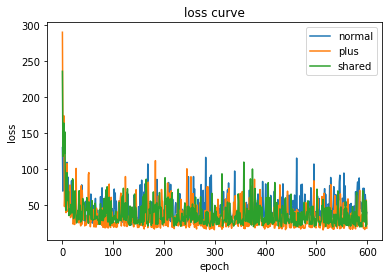

In [40]:
# plot loss curve
loss = {}
power=50
#for name in train_model_names:
for name in train_model_names:
    loss[name] = torch.load(show_path + name + '_losspath.pt')['train loss']
    plt.plot(loss[name],label=name)

plt.legend(loc='best')
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig(fig_path + f'W120-D3-P{power}'+'loss.png')

In [4]:
## 待办事项
'''
**1. 可视化参数，看到底是那部分起作用
2. 加宽，加深 网络，或者改变网络架构 （Transformer）
3. 数据增广， 看泛化
4. 学习率策略: 0.001

width: 20,60,100
depth: 2,3,4
power: [50,50], [50,60]
'''

'''
1. meta net 结构调整
(1) complex CNN
(2) complex RNN,Transformer  加入历史信息 S = phi(u_i, u_{i-1})

2.noise term
n  -->  n * u

3. channel num, 16 QAM

'''

'\n**1. 可视化参数，看到底是那部分起作用\n2. 加宽，加深 网络，或者改变网络架构 （Transformer）\n3. 数据增广， 看泛化\n4. 学习率策略: 0.001\n\nwidth: 20,60,100\ndepth: 2,3,4\npower: [50,50], [50,60]\n'

In [19]:
########################### Fiber #############################
# fiber channel
x, symbol_stream, bit_stream = tx.wdm_signal_sample()
y = fiber(x)
z = {}

# compensation
z['full'] = comp['full'](y)
for name in model_names:
    z[name] = comp[name](y[k:k+1])

# receiver side
I = {}
I['no comp'] = rx.filter(y[k], Nch=k)
I['full'] = rx.filter(z['full'][k],Nch=k)
for name in model_names:
    I[name] = rx.filter(z[name][0], Nch=k)


In [3]:
from complex_layers import complex_conv1d
from torch import nn
conv1 = complex_conv1d(3,6)
x = torch.rand(10,3,100) + 1j
conv1(x).shape

torch.Size([10, 6, 98])

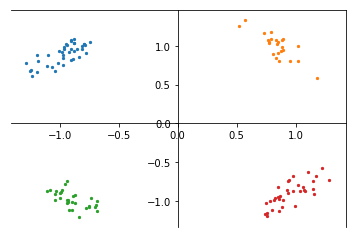

In [45]:
'''
'scale', 'plus', 'scale+plus' 为什么会相同的loss曲线
'''
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch,generate_noise=True,noise_level=1e-3)
dsp = Fiber(tx.lam_set,length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=200,Nch=config.Nch)
x,s,_ = tx.wdm_signal_sample()

z = x
for i in range(10):
    y = fiber(z)
    z = dsp(y)
I = rx.filter(z[0],Nch=1)
rx.show_symbol(I,s[0])

In [39]:
512*128

65536